# Проект по А/B-тестированию

### Описание проекта

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

### Техническое задание

- Название теста: recommender_system_test.


- Группы: А (контрольная), B (новая платёжная воронка).


- Дата запуска: 2020-12-07.


- Дата остановки набора новых пользователей: 2020-12-21.


- Дата остановки: 2021-01-04.


- Аудитория: 15% новых пользователей из региона EU.


- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.


- Ожидаемое количество участников теста: 6000.

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

          - конверсии в просмотр карточек товаров — событие product_page
          - просмотры корзины — product_cart
          - покупки — purchase.
          
          
- Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

### Описание данных

**/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год:**
  
- name — название маркетингового события
- regions — регионы, в которых будет проводиться рекламная кампания
- start_dt — дата начала кампании
- finish_dt — дата завершения кампании

**/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:**

- user_id — идентификатор пользователя
- first_date — дата регистрации
- region — регион пользователя
- device — устройство, с которого происходила регистрация

**/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:**

- user_id — идентификатор пользователя
- event_dt — дата и время события
- event_name — тип события
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах

**/datasets/final_ab_participants.csv — таблица участников тестов:**

- user_id — идентификатор пользователя
- ab_test — название теста
- group — группа пользователя

### Цели исследования

- Оценить корректность проведения теста.


- Проанализировать результаты теста.

###  План выполнения 

1. Предобработка.


2. Оценка корректности проведения теста.


3. Проведение исследовательского анализа.


4. Проведение оценки результатов A/B-тестирования.


5. Выводы.

### Импорт нужных библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import numpy as np

C:\Users\79156\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Загрузка датасетов

In [2]:
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    

try:
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    new_users = pd.read_csv('final_ab_new_users.csv')
    

try:
    events = pd.read_csv('/datasets/final_ab_events.csv')
except:
    events = pd.read_csv('final_ab_events.csv')
    
    
try:
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    participants = pd.read_csv('final_ab_participants.csv')

### Ознакомление с данными и их предобработка

In [3]:
pd.set_option('display.max_colwidth', None)
display(marketing_events)
display(new_users.head())
display(events.head())
display(participants.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**Проверим типы данных**

In [4]:
display(marketing_events.info())
display(new_users.info())
display(events.info())
display(participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

В датафреймах: marketing_events, new_users и ab_events в столбцах с датами изменим данные с object на datetime.

In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

**Проверим данные на пропуски**

In [6]:
display(marketing_events.isna().sum())
display(new_users.isna().sum())
display(events.isna().sum())
display(participants.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

user_id    0
group      0
ab_test    0
dtype: int64

In [7]:
pd.DataFrame(round(events.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
details,85.800000
user_id,0.000000
event_dt,0.000000
event_name,0.000000


Пропуски есть только в столбце details датафрейма events, пропусков 85%. Ничего с пропусками делать не будем, так как эти данные для теста не понадобятся.

**Проверим данные на дубликаты**

In [8]:
display(marketing_events.duplicated().sum())
display(new_users.duplicated().sum())
display(events.duplicated().sum())
display(participants.duplicated().sum())

0

0

0

0

Дубликатов в данных нет.

**Вывод по предабробке:**

**Ознакомился с данными.**

**В датафреймах: marketing_events, new_users и events в столбцах с датами изменил данные с object на datetime.**

**Пропуски есть только в столбце details датафрейма events. Ничего с пропусками не делали, так как эти данные для теста не понадобятся.**

**Дубликатов в данных нет.**

### Оценка корректности проведения теста.

**Проверим соответствие данных требованиям технического задания**

In [9]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Пользователей, учавствующих в тесте recommender_system_test 6701 человек.

In [10]:
participants.loc[participants['ab_test'] == 'recommender_system_test', 'group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [11]:
participants.loc[participants['ab_test'] == 'recommender_system_test', 'group'].value_counts(normalize=True) * 100

A    57.06611
B    42.93389
Name: group, dtype: float64

В группе A - 3824 пользователя, 

В группе B - 2877 пользователя

In [12]:
print('Дата запуска регистрации новых пользователей:', new_users['first_date'].min()) 
print('Дата остановки регистрации новых пользователей:', new_users['first_date'].max())

Дата запуска регистрации новых пользователей: 2020-12-07 00:00:00
Дата остановки регистрации новых пользователей: 2020-12-23 00:00:00


Удалим пользователей, которые зарегистрировались после 21 декабря

In [13]:
new_users = new_users.loc[new_users['first_date'] <= '2020-12-21']

In [14]:
print('Дата запуска регистрации новых пользователей:', new_users['first_date'].min()) 
print('Дата остановки регистрации новых пользователей:', new_users['first_date'].max())

Дата запуска регистрации новых пользователей: 2020-12-07 00:00:00
Дата остановки регистрации новых пользователей: 2020-12-21 00:00:00


Теперь даты регистрации соответсвтуют ТЗ.

In [15]:
print('Дата начала событий пользователей:', events['event_dt'].min()) 
print('Дата конца событий пользователей:', events['event_dt'].max())

Дата начала событий пользователей: 2020-12-07 00:00:33
Дата конца событий пользователей: 2020-12-30 23:36:33


- Объединим датафрейм new_users (все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года) и participants (таблица участников тестов)

In [16]:
new_users_participated = new_users.merge(participants, on='user_id', how='left')
new_users_participated.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN


In [17]:
count_eu = new_users_participated['region'].value_counts()['EU']
print('Количество новых пользователей из Европы:', count_eu)

Количество новых пользователей из Европы: 43942


In [18]:
#КОД РЕВЬЮЕРА
count_eu = new_users_participated[new_users_participated['region'] == "EU"]['user_id'].nunique()
print('Количество новых пользователей из Европы:', count_eu)

Количество новых пользователей из Европы: 42340


In [19]:
count_eu_test = len(new_users_participated[(new_users_participated['ab_test'] == 'recommender_system_test') & \
                                   (new_users_participated['region'] == 'EU')])
print('Количество новых пользователей из Европы, учавсвующих в тесте:', count_eu_test)

Количество новых пользователей из Европы, учавсвующих в тесте: 6351


In [20]:
result = count_eu_test / count_eu
print('Доля участников теста из Европы от новых пользователей из Европы', round(result, 2))

Доля участников теста из Европы от новых пользователей из Европы 0.15


**Посмотрим время проведения теста, проверим не совпадает ли с маркетинговыми и другими активностями**

In [21]:
marketing_events[(marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['finish_dt'] <= '2021-01-30')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


- Время теста совпадает с проведением двух Новогодних акций. Одна из них проводилась в Европе, Christmas&New Year Promo. Это могло повлиять значительно на результаты теста.

- Не очень хорошая идея проводить тест в преддверии Нового года.

**Посмотрим на аудиторию теста**

**Проверим нет ли пересечений с конкурирующим тестом**

In [22]:
user_tests = participants.groupby('user_id')['ab_test'].nunique()
users_double_tets = user_tests[user_tests > 1].index
users_double_tets_count = len(users_double_tets)
print('количество пользователей, которые попали в оба теста:', users_double_tets_count)

count_users = len(participants['user_id'])
percent = users_double_tets_count / count_users
print('Процент пользователей, которые попали в оба теста:', round(percent, 2))

количество пользователей, которые попали в оба теста: 1602
Процент пользователей, которые попали в оба теста: 0.09


- Удалим этих пользователей, так как они могут исказить рузльтаты теста, так как не нельзя будет точно сказать, какой из тестов повлиял на решение пользователей

- И удалим пользователей из теста interface_eu_test

In [23]:
participants = participants[~participants['user_id'].isin(users_double_tets)]

participants = participants.query('ab_test != "interface_eu_test"')

**Проверим равномерность распределения пользователей по тестовым группам**

- Выделим участников только из Европы, учавствующих в тесте

In [24]:
eu_df = new_users_participated[(new_users_participated['region'] == 'EU') & (new_users_participated['ab_test'] == 'recommender_system_test')]

In [25]:
print('Количество уникалных пользователей в двух группах теста:', eu_df['user_id'].nunique())
print ('Количество пользователей в группе A = ', len(eu_df.query('group == "A"')))
print ('Количество пользователей в группе B = ', len(eu_df.query('group == "B"')))
print ('Доля пользователей группы A = ', round(len(eu_df.query('group == "A"')) / len (eu_df), 2))
print ('Доля пользователей группы B = ', round(len(eu_df.query('group == "B"')) / len (eu_df), 2))

Количество уникалных пользователей в двух группах теста: 6351
Количество пользователей в группе A =  3634
Количество пользователей в группе B =  2717
Доля пользователей группы A =  0.57
Доля пользователей группы B =  0.43


Пользователей в группе A на 14% больше чем в группе B. В идеале должно быть по ровну

**Вывод по оценки корректности проведения теста:**

- **Количество участников теста достаточно, 6351 новых пользователей из Европы.**


- **В группе A 57% пользователей(3634), в группе B 43%(2717).**


- **Дата запуска регистрации новых пользователей совпадает: 2020-12-07. А дата остановки регистрации новых пользователей не совпадает: 2020-12-23. Погрешность в 2 дня. Удалили пользователей, зарегистрировавшихся после 21 декабря**


- **Дата начала событий пользователей совпадает 2020-12-07. А дата конца событий пользователей нет: 2020-12-30. По условию задачи последний день событий:  2021-01-04. Это значит, что не все пользователи смогут завершить действия в течение 14 после регистрации.**


- **Время теста совпадает с проведением двух Новогодних акций. Одна из них проводилась в Европе, Christmas&New Year Promo. Это могло повлиять значительно на результаты теста.**


- **Удалили пользователей, которые попали в оба теста(recommender_system_test и interface_eu_test) и удалили всех пользователей, которые попали в тест interface_eu_test**


- **Пользователей в группе A на 14% больше чем в группе B.**


**Можно сделать вывод, что данные для теста не корректны. Доверять результатам теста нельзя.**

### Проведение исследовательского анализа

- Объединим датафрейм events (все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года) и participants (таблица участников тестов)

In [26]:
merged_df = events.merge(participants, on='user_id', how='left')
merged_df.head()

,user_id,event_dt,event_name,details,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,NaN,NaN
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,NaN,NaN


**Посмотрим одинаково ли распределены количество событий на пользователя в выборках**

In [27]:
grouped_df = merged_df.groupby(['group', 'user_id']).agg({'event_name': 'count'}).reset_index()
mean_events = grouped_df.groupby('group').agg({'event_name': 'mean'})
mean_events.round(0)

,event_name
group,
A,7.0
B,6.0


- В группе A на пользователя в среднем приходится 7 событий
- В группе B на пользователя в среднем приходится 6 событий
- Это может быть связано с тем, что в группе A больше пользовтелей на 14%

**Посмотрим как число событий в выборках распределено по дням**

In [28]:
merged_df['event_dt'] = merged_df['event_dt'].dt.date

events_by_date = (merged_df.groupby(['event_dt', 'group'], as_index=False)['user_id'].count()
                                .rename(columns={'user_id':'events_count'}))
events_by_date.head()

,event_dt,group,events_count
0,2020-12-07,A,234
1,2020-12-07,B,290
2,2020-12-08,A,267
3,2020-12-08,B,183
4,2020-12-09,A,296


In [44]:
fig = px.line(events_by_date, x='event_dt', y='events_count', color='group', title='Распределение событий по дням')
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество событий')
fig.show()

- Видим, что в группе A начался резкий рост событий 13 декабря и на спад количество событий пошло 21 декабря после своего пика.
- После 29 декабря в группе A нет информации о событиях пользователей.
- В Группе B количество событий на протяжении всего теста равномерное, но 30 декабря количество событий на нуле.

**Посмотрим как меняется конверсия в воронке в выборках на разных этапах в разбивке польователей по группам теста (A и B)**

Есть 4 типа событий пользователей:

- login - авторизация на сайте
- product_page - просмотр карточек товаров
- product_cart - просмотры корзины
- purchase - покупки

In [45]:
!pip install plotly --upgrade

In [46]:
funnel_data = merged_df.groupby(['group', 'event_name'], as_index=False).agg({'user_id': pd.Series.nunique})

event_order = ['login', 'product_page', 'product_cart', 'purchase']
funnel_data['event_name'] = pd.Categorical(funnel_data['event_name'], categories=event_order, ordered=True)

funnel_data = funnel_data.sort_values('event_name')

fig = px.funnel(funnel_data, x='user_id', y='event_name', color='group', orientation='h')

fig.update_traces(textposition='inside', textinfo='value+percent initial', opacity=0.65)

fig.update_layout(title='Диаграмма воронки', title_x=0.5, width=1000, height=600)

fig.show()


- В группе A конверсия:
                       - в просмотр карточки товара - 65%
                       - в просмотр корзины 30%
                       - в покупки 31%
                       
- В группе B конверсия:
                       - в просмотр карточки товара - 56%
                       - в просмотр корзины 28%
                       - в покупки 28%
                       
- Конверсия в покупки у обеих групп немного выше, чем конверсия в просмотр корзины. Это связано с тем, что можно сделать заказ, не заходя в корзину. Эту особенность нужно учесть прежде чем приступать к A/B-тестированию. 


**Вывод по исследовательскому анализу:**

- **В группе A на пользователя в среднем приходится 7 событий, а в группе B 6 событий.**


- **В группе A больше пользовтелей на 14% чем в группе B.**


- **В группе A начался резкий рост событий 13 декабря и на спад количество событий пошло 21 декабря после своего пика. После 29 декабря в группе A нет информации о событиях пользователей. В Группе B количество событий на протяжении всего теста равномерное, но 30 декабря количество событий на нуле.**


- **Купить товар можно, не заходя в корзину. В этом случае нельзя точно сказать какое действие совершил пользователь после просмотра карточки. Эту особенность нужно учесть прежде чем приступать к A/B-тестированию.**


**Это подтверждает ещё раз, что тест проведён некорректно.**

### Оценка результатов A/B-тестирования

- Построим функции по сбору кумулятивных данных и построению графиков

In [47]:
def cumulative_data(df, event):
    
    # Выбираем из данных строки с заданным событием
    df_filtred_event = df.query('event_name == @event')
    # Создадим массив уникальных пар значений дат и групп теста 
    datesGroups = df_filtred_event[['event_dt','group']].drop_duplicates()
    
    # Соберём агрегированные кумулятивные данные о покупках по дням
    df_purchase_agg = datesGroups.apply(lambda x: df_filtred_event[np.logical_and(df_filtred_event['event_dt'] <= x['event_dt'],
                                                                           df_filtred_event['group'] == x['group'])]
                                      .agg({'event_dt': 'max', 'group': 'max', 'user_id': 'nunique'}),
                                                                            axis=1).sort_values(by=['event_dt','group'])
    
    # Соберём агрегированные кумулятивные данные о покупателях
    df_buyers_agg = datesGroups.apply(lambda x: df_filtred_event[np.logical_and(df_filtred_event['event_dt'] <= x['event_dt'],
                                                                         df_filtred_event['group'] == x['group'])]
                                    .agg({'event_dt': 'max', 'group': 'max', 'user_id': 'count'}),
                                                                            axis=1).sort_values(by=['event_dt','group'])
    
    # Объединим кумулятивные данные в одной таблице и переименуем столбцы
    result = df_purchase_agg.merge(df_buyers_agg, on=['event_dt','group'])
    result.columns = ['date', 'group', 'visitors', 'orders']
    return result


In [48]:
# Соберём кумулятивные значения для анализа относительных показателей и события "просмотр карточек"
cumulativeData_product_page = cumulative_data(merged_df, 'product_page')

# добавляем столбец расчета конверсии
cumulativeData_product_page['conversion'] = cumulativeData_product_page['orders']/cumulativeData_product_page['visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeData_product_page_A = cumulativeData_product_page.query('group == "A"')

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В
cumulativeData_product_page_B = cumulativeData_product_page.query('group == "B"')

In [49]:
# Функция построения сравнительного графика
def plot_conversion(cumulativeData_A, cumulativeData_B, column, date, title, ylabel):
    
    """ 
        Функция для отображения кумулятивной конверсии в разбивке по группам
    
    """
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(18,6))
    ax.set(title=title, xlabel='дата', ylabel=ylabel)
    ax.plot(cumulativeData_A['date'], cumulativeData_A[column])
    ax.plot(cumulativeData_B['date'], cumulativeData_B[column])
    ax.plot(cumulativeData_A['date'], cumulativeData_A[column], '.-',label='A')
    ax.plot(cumulativeData_B['date'], cumulativeData_B[column], '.-',label='B' )
    ax.legend() 
    

    plt.show()

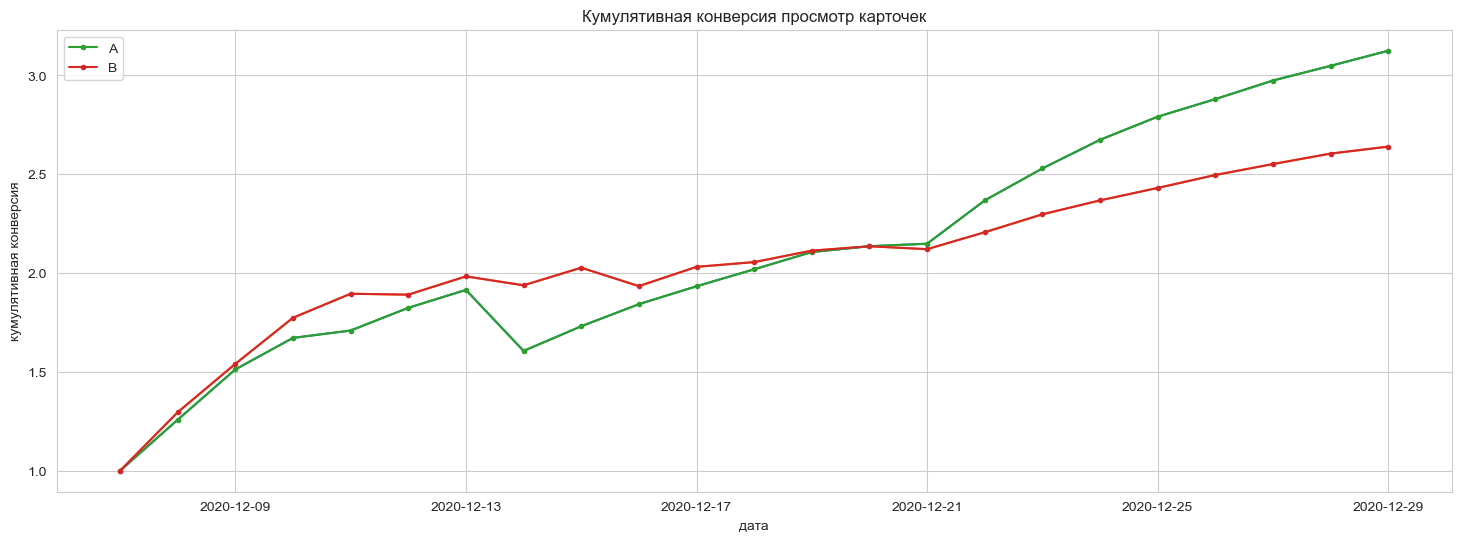

In [50]:
# построение графика
plot_conversion(cumulativeData_product_page_A, cumulativeData_product_page_B,
                'conversion', 'date', 'Кумулятивная конверсия просмотр карточек', 'кумулятивная конверсия')

In [51]:
# аналогично для корзины
cumulativeData_product_cart = cumulative_data(merged_df, 'product_cart')
cumulativeData_product_cart['conversion'] = cumulativeData_product_cart['orders']/cumulativeData_product_cart['visitors']
cumulativeData_product_cart_A = cumulativeData_product_cart.query('group == "A"')
cumulativeData_product_cart_B = cumulativeData_product_cart.query('group == "B"')

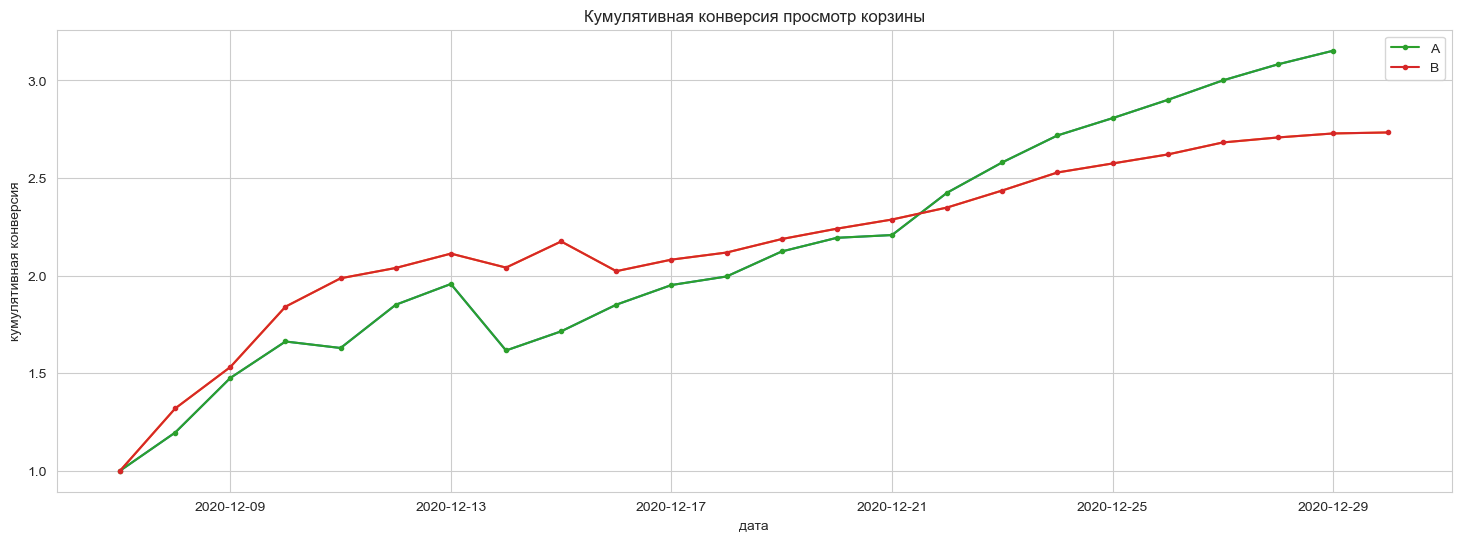

In [37]:
# построение графика
plot_conversion(cumulativeData_product_cart_A, cumulativeData_product_cart_B,
                'conversion', 'date', 'Кумулятивная конверсия просмотр корзины', 'кумулятивная конверсия')

In [38]:
# анлогично для покупки
cumulativeData_purchase = cumulative_data(merged_df, 'purchase')
cumulativeData_purchase['conversion'] = cumulativeData_purchase['orders']/cumulativeData_purchase['visitors']
cumulativeData_purchase_A = cumulativeData_purchase.query('group == "A"')
cumulativeData_purchase_B = cumulativeData_purchase.query('group == "B"')

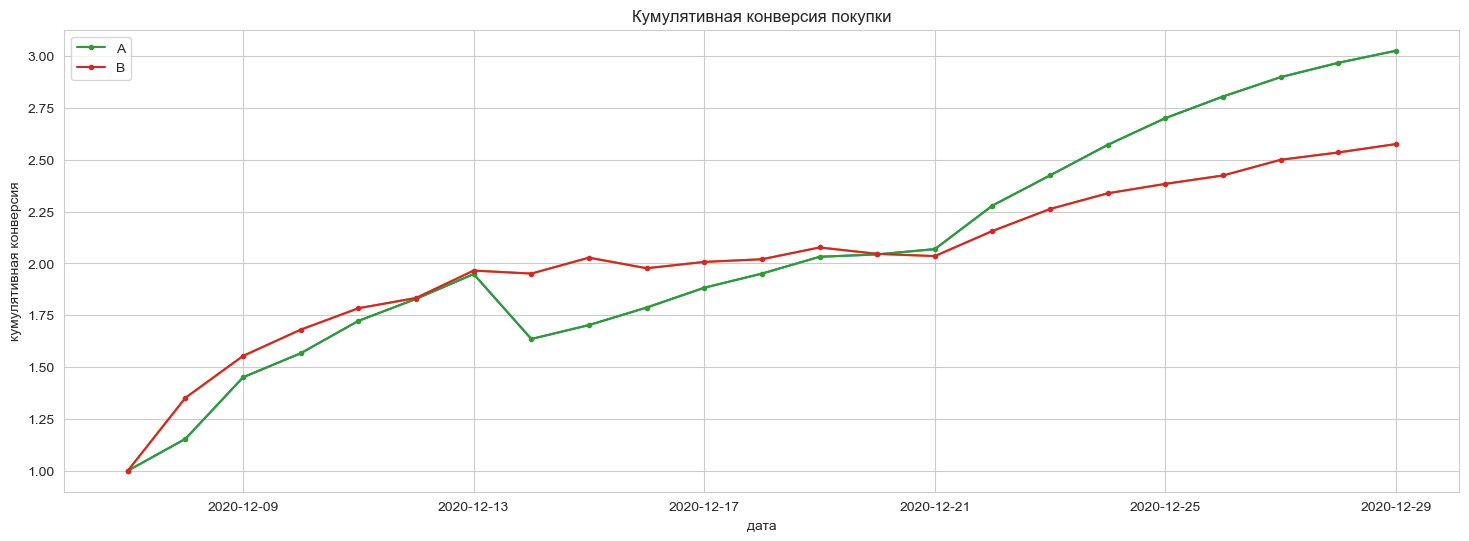

In [39]:
# построение графика
plot_conversion(cumulativeData_purchase_A, cumulativeData_purchase_B, 'conversion', 'date',
          'Кумулятивная конверсия покупки', 'кумулятивная конверсия')

- Комулятивная конверсия в просмотр карточек товаров равномерно росла в обеих группах до 9 декабря. Далее группа B вырвалась вперёд и лидировала до 21 декабря. после 21 числа группа резко вырвалась вперёд и лидировала до конца теста.


- Комулятивная конверсия в просмотр корзины в группе B лидировала до 22 декабря, далее группа A вырвалась вперёд и лидировала также до конца теста.


- Комулятивная конверсия в покупки в группе B лидировала до 20 декабря, но 21 числа группа A вырвалась вперёд и лидировала также до конца теста.


- **Видим, что на всех этапах пользовательских событий группа A резко вырывается вперёд по конверсии после 21 числа. Это число остановка набора новых пользователей.**

**Проверим статистическую разницу долей z-критерием**

- Создадим функцию для проверки статистической разницы долей z-критерием.

Гипотеза № 1:

- Нулевая гипотеза: Среднее количество пользователей дошедших до product_cart в группах A и B значимо не различается
- Альтернативная: Среднее количество пользователей дошедших до product_cart в группах A и B значимо различается


Гипотеза № 2:

- Нулевая гипотеза: Среднее количество пользователей дошедших до product_page в группах A и B значимо не различается
- Альтернативная: Среднее количество пользователей дошедших до product_page в группах A и B значимо различается


Гипотеза № 3:

- Нулевая гипотеза: Среднее количество пользователей дошедших до purchase в группах A и B значимо не различается
- Альтернативная: Среднее количество пользователей дошедших до purchase в группах A и B значимо различается

In [40]:
def z_test_diff_proportions(df, event_name):
    
    # количество пользователей в группе A и B для заданного события
    count_A = df[(df['event_name'] == event_name) & (df['group'] == 'A')]['user_id'].nunique()
    count_B = df[(df['event_name'] == event_name) & (df['group'] == 'B')]['user_id'].nunique()

    # количество всех пользователей в группе A и B
    nobs_A = df[df['group'] == 'A']['user_id'].nunique()
    nobs_B = df[df['group'] == 'B']['user_id'].nunique()

    # проводим z-тест для разности долей
    z_stat, p_value = proportions_ztest([count_A, count_B], [nobs_A, nobs_B])

    # возвращаем результаты теста с подписью p-значения
    return z_stat, f"p-значение: {p_value:.4f}"

In [41]:
z_test_diff_proportions(merged_df, 'product_cart')

(1.3511926078890857, 'p-значение: 0.1766')

In [42]:
z_test_diff_proportions(merged_df, 'product_page')

(4.323290515683279, 'p-значение: 0.0000')

In [43]:
z_test_diff_proportions(merged_df, 'purchase')

(1.6313443715574993, 'p-значение: 0.1028')

**Вывод по оценке результатов A/B-тестирования:**


- **На всех этапах пользовательских событий группа A резко вырывается вперёд по конверсии после 21 числа. Это число остановка набора новых пользователей**


- **Среднее количество пользователей дошедших до product_cart в группах A и B значимо не различается**


- **Среднее количество пользователей дошедших до product_page в группах A и B значимо различается**


- **Среднее количество пользователей дошедших до purchase в группах A и B значимо не различается**

### Общий вывод

- **Время теста совпадает с проведением Новогодней акции в Европе. Это могло повлиять значительно на результаты теста. Пользователей в группе A на 14% больше чем в группе B.**


- **Купить товар можно, не заходя в корзину. В этом случае нельзя точно сказать какое действие совершил пользователь после просмотра карточки.**


- **Это указывает, что данные для теста не корректны. Доверять результатам теста нельзя.**


**В процессе исследовательского анализа выявили, что:**


- **В группе B также уменьшилась конверсия в просмотр карточки товара в сравнении с группой A на 9%, в просмотр корзины на 2, в покупки на 2%.**


**По итогам оценки результатов A/B-тестирования обнаружили, что**


- **На всех этапах пользовательских событий группа A резко вырывается вперёд по конверсии после 21 числа. Это число остановка набора новых пользователей.**


- **Среднее количество пользователей в группах A и B дошедших до разных этапов не значимо не различается кроме product_page. Среднее количество пользователей дошедших до карточи товаров имеет значимые различия.**


### Итог:

- **Ожидаемый эффект от внедрения улучшенной рекомендательной системы не подтвердился. Конверсия стала только ещё хуже.**


- **Но так как данные для теста не корректные, нельзя полагаться на достоверность результата теста.**